In [1]:
import jax.numpy as jnp
import jax
from jax import vmap, jit, grad
import optax
from functools import partial
import numpy as np
from tqdm import trange
from jax import random
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../')

from KANWrapper import SF_KAN  # Base KAN implementation

def create_domain_points(X_range, T_range, nx, nt):
    """Create domain points for 1D spatial + time domain"""
    x = np.linspace(X_range[0], X_range[1], nx)
    t = np.linspace(T_range[0], T_range[1], nt)
    
    # Interior points
    X, T = np.meshgrid(x[1:-1], t[1:], indexing='ij')  # Exclude boundaries
    interior_points = np.column_stack((X.ravel(), T.ravel()))
    
    # Boundary points (x = -1 and x = 1, t ≥ 0)
    x_boundary = np.vstack([
        np.column_stack((np.full(nt, X_range[0]), t)),  # Left boundary
        np.column_stack((np.full(nt, X_range[1]), t))   # Right boundary
    ])
    
    # Initial condition (t = 0)
    ic_points = np.column_stack((x, np.zeros_like(x)))
    
    # Combine all boundary and initial condition points
    boundary_points = np.vstack([x_boundary, ic_points])
    
    return interior_points, boundary_points


X_range = (-1.0, 1.0)
T_range = (0.0, 1.0)
nx, nt = 320, 160
interior_points, boundary_points = create_domain_points(X_range, T_range, nx, nt)

print(interior_points.shape)
print(boundary_points.shape)

(50562, 2)
(640, 2)


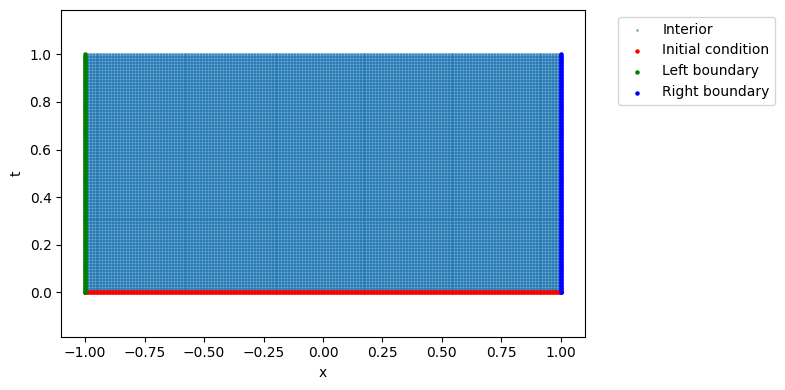

In [2]:
def plot_domain_setup(interior_points, boundary_points):
    plt.figure(figsize=(8, 4))
    
    # Separate boundary points into initial condition and boundaries
    t_zero_mask = boundary_points[:, 1] == 0
    x_left_mask = boundary_points[:, 0] == -1
    x_right_mask = boundary_points[:, 0] == 1
    
    # Plot interior points
    plt.scatter(interior_points[:, 0], interior_points[:, 1], 
               s=1, alpha=0.5, label='Interior')
    
    # Plot initial and boundary points
    plt.scatter(boundary_points[t_zero_mask, 0], boundary_points[t_zero_mask, 1], 
               s=5, c='r', label='Initial condition')
    plt.scatter(boundary_points[x_left_mask, 0], boundary_points[x_left_mask, 1], 
               s=5, c='g', label='Left boundary')
    plt.scatter(boundary_points[x_right_mask, 0], boundary_points[x_right_mask, 1], 
               s=5, c='b', label='Right boundary')
    
    plt.xlabel('x')
    plt.ylabel('t')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
# Plot the domain setup
plot_domain_setup(interior_points, boundary_points)


In [3]:

class AllenCahn_KAN(SF_KAN):
    def __init__(self, *args, D=0.01, **kwargs):
        super().__init__(*args, **kwargs)
        self.D = D  # Diffusion coefficient
    
    @partial(jit, static_argnums=(0,))
    def initial_condition(self, x):
        """Initial condition u(x,0) = x^2 cos(π x)"""
        return x**2 * jnp.cos(jnp.pi * x)
    
    @partial(jit, static_argnums=(0,))
    def boundary_condition(self, t):
        """Boundary condition u(±1,t) = -1"""
        return -1.0

    @partial(jit, static_argnums=(0,))
    def loss_fn(self, params, state, xy_domain, xy_boundary):
        variables = {'params': params, 'state': state}
        
        # Get predictions for domain and boundary points
        pred_domain, spl_regs = self.forward_pass(variables, xy_domain)
        pred_boundary, _ = self.forward_pass(variables, xy_boundary)

        # Physics loss (Allen-Cahn equation)
        def ac_residual(point):
            x, t = point

            def u(p):
                return self.forward_pass(variables, p.reshape(1, -1))[0][0, 0]

            # Compute derivatives
            u_t = grad(lambda t_var: u(jnp.array([x, t_var])))(t)
            u_xx = grad(lambda x_var: grad(lambda x_var: u(jnp.array([x_var, t])))(x_var))(x)
            
            u_val = u(jnp.array([x, t]))
            
            # Residual of the Allen-Cahn equation
            # du/dt - D d²u/dx² + 5(u³ - u) = 0
            residual = u_t - self.D * u_xx + 5.0 * (u_val**3 - u_val)
            return residual

        # Vectorize residual computation over domain points
        physics_residuals = vmap(ac_residual)(xy_domain)
        physics_loss = jnp.mean(physics_residuals**2)

        # Boundary and initial condition losses
        def boundary_loss_fn(point):
            x, t = point
            pred = self.forward_pass(variables, point.reshape(1, -1))[0][0, 0]
            target = jnp.where(t == 0, 
                             self.initial_condition(x),  # Initial condition at t=0
                             self.boundary_condition(t)) # Boundary condition at x=±1
            return pred - target

        boundary_residuals = vmap(boundary_loss_fn)(xy_boundary)
        boundary_loss = jnp.mean(boundary_residuals**2)

        # Regularization loss from spline regularization terms
        flattened_spl_reg = [jnp.ravel(arr) for arr in spl_regs]
        reg_loss = jnp.sum(jnp.concatenate(flattened_spl_reg))

        # Total loss
        total_loss = physics_loss + boundary_loss # + 0.1 * reg_loss
        return total_loss



In [ ]:
# Model parameters
layer_dims = [2, 9, 9, 1]
init_lr = 1e-3

# Allen-Cahn equation parameters
D = 1e-4

# Initialize model
model = AllenCahn_KAN(
    layer_dims=layer_dims,
    init_lr=init_lr,
    k=5,
    D=D
)

# Train the model
num_epochs = 100000
final_variables, loss_history = model.train(
    num_epochs=num_epochs,
    xy_domain=interior_points,
    xy_boundary=boundary_points
)

In [ ]:
# Plot loss history
def plot_loss_history(loss_history):
    plt.figure(figsize=(6, 5))
    epochs = range(0, len(loss_history), 100)
    plt.plot(epochs, loss_history[::100])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')  # Use log scale for y-axis
    plt.grid(True)
    plt.show()

plot_loss_history(loss_history)


In [ ]:

# Generate solution
nx_plot, nt_plot = nx, nt
x_plot = np.linspace(-1, 1, nx_plot)
t_plot = np.linspace(0, 1, nt_plot)
X_mesh, T_mesh = np.meshgrid(x_plot, t_plot)
xt_plot = np.column_stack((X_mesh.ravel(), T_mesh.ravel()))
u_pred, _ = model.forward_pass({'params': final_variables['params'], 'state': final_variables['state']}, jnp.array(xt_plot))
u_pred = u_pred.reshape(nt_plot, nx_plot)

# Plot the predicted solution
plt.figure(figsize=(5, 8))
plt.contourf(T_mesh, X_mesh, u_pred, levels=50, cmap='hsv')
plt.colorbar(label='u(x,t)')
plt.xlabel('t')
plt.ylabel('x')
plt.title('u_pred')
plt.tight_layout()
plt.show()


In [7]:
# Create dictionary with all field data
output_data = {
    'x': x_plot,
    't': t_plot,
    'u': u_pred,
    'D': 1e-4
}

# Save data
np.save(f'./data/allen_cahn_pikan_nx{nx}_nt{nt}_{layer_dims}_epochs{num_epochs}.npy', output_data)


In [11]:
def count_trainable_params(params):
    flat_params, _ = jax.tree_util.tree_flatten(params)
    return sum(p.size for p in flat_params)

num_params = count_trainable_params(final_variables['params'])
print(f"Number of trainable parameters: {num_params}")

Number of trainable parameters: 331
